### Visuals
This is just a test notebook to create visuals and find general info for the demo and thesis document.

In [1]:
import os
from pathlib import Path
import librosa
import re
from time import time
import ast
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import Audio, display
import soundfile as sf
from scipy.io import wavfile

from src.utils.SpectrogramExtractor import SpectrogramExtractor
from src.model import ConvCount, ConvVAD, config, config_postVAD, config_VAD
from src.utils.helpers import *

In [2]:
import torch
import torch.nn as nn
from torchsummary import summary

# Load the model
model_path = r"src\model\ConvVAD.pt"
model = torch.load(model_path, map_location=torch.device('cpu'))


model = ConvVAD(**config_VAD)  # Define your model class
model.load_state_dict(torch.load(model_path))

# Print model summary
summary(model, input_size=(1, 64, 101))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 64, 101]             320
       BatchNorm2d-2          [-1, 32, 64, 101]              64
         MaxPool2d-3           [-1, 32, 32, 50]               0
            Conv2d-4           [-1, 64, 32, 50]          18,496
       BatchNorm2d-5           [-1, 64, 32, 50]             128
         MaxPool2d-6           [-1, 64, 16, 25]               0
           Dropout-7                [-1, 25600]               0
            Linear-8                   [-1, 64]       1,638,464
            Linear-9                    [-1, 2]             130
Total params: 1,657,602
Trainable params: 1,657,602
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 5.50
Params size (MB): 6.32
Estimated Total Size (MB): 11.85
--------------------------------------

In [3]:
# Load the model
model_path = r"src\model\ConvCount_5_OptunaResults_F1_234.pt"
model = torch.load(model_path, map_location=torch.device('cpu'))


model = ConvCount(**config)  # Define your model class
model.load_state_dict(torch.load(model_path))

# Print model summary
summary(model, input_size=(1, 64, 101))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 64, 101]              80
       BatchNorm2d-2           [-1, 8, 64, 101]              16
         MaxPool2d-3            [-1, 8, 32, 50]               0
            Conv2d-4           [-1, 32, 32, 50]           2,336
       BatchNorm2d-5           [-1, 32, 32, 50]              64
         MaxPool2d-6           [-1, 32, 16, 25]               0
            Conv2d-7          [-1, 128, 16, 25]          36,992
       BatchNorm2d-8          [-1, 128, 16, 25]             256
         MaxPool2d-9           [-1, 128, 8, 12]               0
           Conv2d-10           [-1, 128, 8, 12]         147,584
      BatchNorm2d-11           [-1, 128, 8, 12]             256
        MaxPool2d-12            [-1, 128, 4, 6]               0
          Dropout-13                 [-1, 3072]               0
           Linear-14                  [

In [27]:
def count_files_in_folder(folder_path):
    return sum(
        1 for entry in os.scandir(folder_path)
        if entry.is_file()
    )

# Count the total dataset size
libri = count_files_in_folder(r"data/clips_libricss")
rir = count_files_in_folder(r"data/clips_rir")
auth = count_files_in_folder(r"data/author_data/clips_real")
print(f"LibriCSS total: {np.floor((libri)/3600)} hr + {np.floor(((libri) % 3600)/60)} min")
print(f"RIR&N total: {np.floor((rir)/3600)} hr + {np.floor(((rir) % 3600)/60)} min")
print(f"Author Data total: {np.floor((auth)/3600)} hr + {np.floor(((auth) % 3600)/60)} min")


print(f"Length of dataset audio: {np.floor((libri + rir + auth)/3600)} hr + {np.floor(((libri + rir + auth) % 3600)/60)} min")
print(f"In seconds (num clips): {libri+rir+auth}")

LibriCSS total: 10.0 hr + 3.0 min
RIR&N total: 0.0 hr + 45.0 min
Author Data total: 2.0 hr + 4.0 min
Length of dataset audio: 12.0 hr + 53.0 min
In seconds (num clips): 46393


In [28]:
# How many samples of each type before and after augmentation?
before = pd.read_csv(r'data/labels/libricss_and_noise.csv')
after = pd.read_csv(r'data/labels/final_labels.csv')

# Count occurrences of each speaker_count
before_counts = before['speaker_count'].value_counts().sort_index()
after_counts = after['speaker_count'].value_counts().sort_index()

print("Before augmentation:")
print(before_counts)

print("\nAfter augmentation:")
print(after_counts)


Before augmentation:
speaker_count
0    11719
1    29309
2     5251
Name: count, dtype: int64

After augmentation:
speaker_count
0     11719
1     29309
2     25251
3     25000
4+    25000
Name: count, dtype: int64


In [8]:
def plot_spectrograms_from_paths(spec_paths, df, hop_ms=10):
    """
    Vertically stacked spectrograms with shared x-axis. Only bottom plot shows axis labels.

    Args:
        spec_paths (list): List of full paths to spectrogram .pt files.
        df (pd.DataFrame): DataFrame with 'spec_dir' and 'speaker_count' columns.
        hop_ms (int): Hop size in milliseconds for time axis calculation.
    """
    n_clips = len(spec_paths)
    fig, axes = plt.subplots(n_clips, 1, figsize=(5, 1.75 * n_clips), sharex=True)

    for idx, (spec_path, ax) in enumerate(zip(spec_paths, axes)):
        spectrogram = torch.load(spec_path).squeeze()

        # Lookup speaker count
        match = df.loc[df['spec_dir'] == spec_path, 'speaker_count']
        speaker_count = match.values[0] if not match.empty else 'Unknown'

        # Time axis
        n_frames = spectrogram.shape[1]
        duration_sec = (n_frames * hop_ms) / 1000

        # Plot
        im = ax.imshow(spectrogram.numpy(), aspect='auto', origin='lower',
                       extent=[0, duration_sec, 0, spectrogram.shape[0]],
                       cmap='magma')

        ax.set_title(f'Speaker Count: {speaker_count}', fontsize=11)

        # Y-axis cleanup
        ax.set_ylabel(
        "(Hz)",    
        rotation=0,            
        labelpad=12,
        va="center" 
        )

        ax.set_yticks([])

        # X-axis formatting
        if idx < n_clips - 1:
            ax.tick_params(axis='x', labelbottom=False)  # Show ticks, hide labels
        else:
            ax.set_xlabel('Time (s)')

    fig.tight_layout()
    cbar = fig.colorbar(im, ax=axes, location='right', shrink=0.6)

    # Set custom ticks: first, middle, last
    cbar_ticks = [im.norm.vmin, (im.norm.vmin + im.norm.vmax) / 2, im.norm.vmax]
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(['-', '0', '+'])

    # Optional: label
    cbar.set_label('Amplitude', rotation=270, labelpad=15)

    plt.show()





# A single spectrogram, no labels or axes
def show_spectrogram(spec_path):
    """
    Display a single spectrogram with no axes, title, or labels.

    Args:
        spec_path (str): Path to the spectrogram .pt file.
    """
    spectrogram = torch.load(spec_path).squeeze()

    plt.imshow(spectrogram.numpy(), aspect='auto', origin='lower', cmap='magma')
    plt.axis('off')
    plt.show()

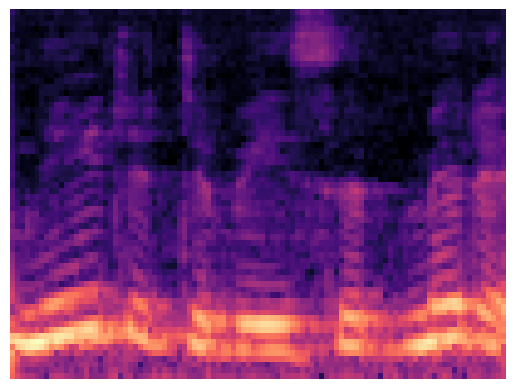

In [9]:
show_spectrogram('data\specs_libricss\OV40_session9_clip150.pt')

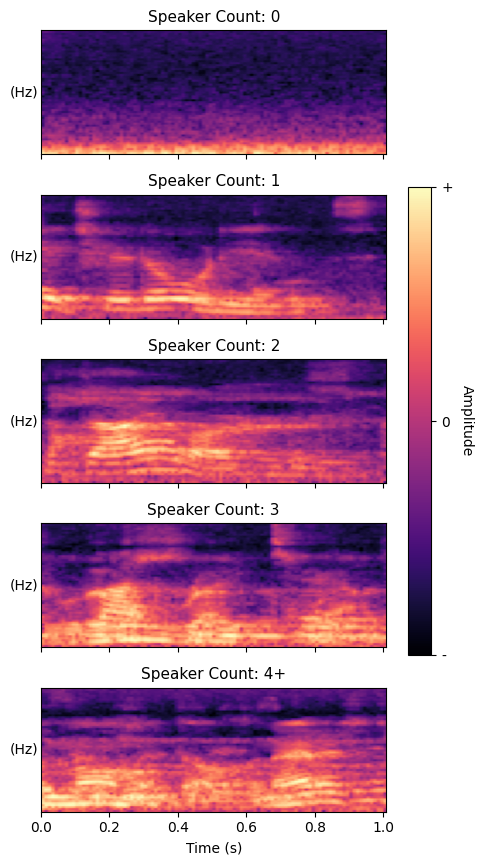

In [ ]:
df = pd.read_csv(r'data/labels/final_labels.csv')

spec_paths = [
     r'data\specs_rir\largeroom1_1_clip1.pt',
     r'data\specs_libricss\0L_session0_clip28.pt',
    r'data\specs_aug\overlay_1.pt',
    r'data\specs_aug\overlay_25500.pt',
    r'data\specs_aug\overlay_52500.pt'
]

plot_spectrograms_from_paths(spec_paths, df)

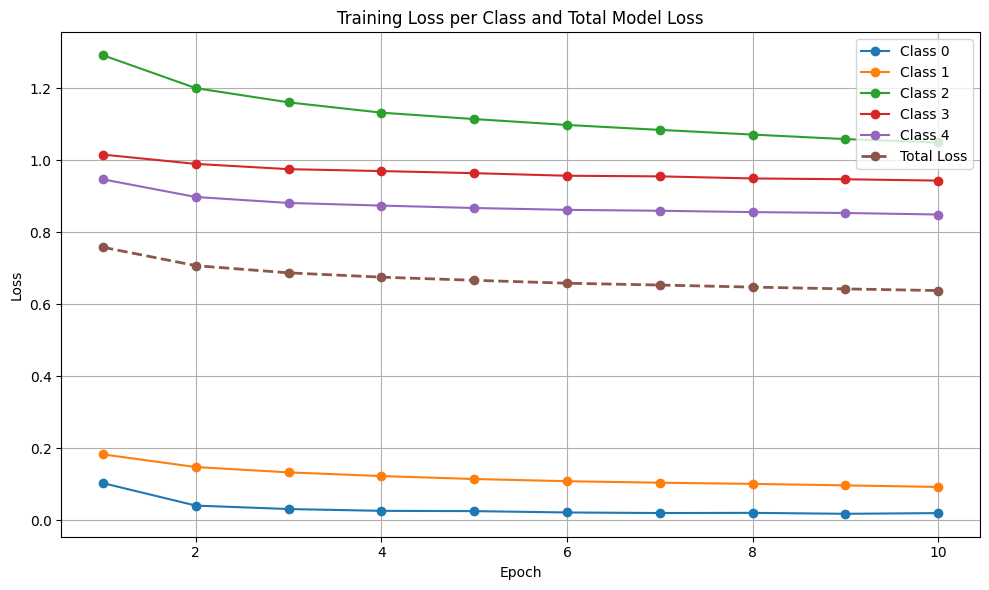

In [5]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 11))

# Per-class losses over epochs
loss_class_0 = [0.1034, 0.0410, 0.0314, 0.0264, 0.0256, 0.0219, 0.0203, 0.0208, 0.0182, 0.0201]
loss_class_1 = [0.1832, 0.1481, 0.1333, 0.1230, 0.1149, 0.1087, 0.1046, 0.1013, 0.0972, 0.0928]
loss_class_2 = [1.2923, 1.2009, 1.1614, 1.1328, 1.1150, 1.0986, 1.0849, 1.0719, 1.0593, 1.0499]
loss_class_3 = [1.0163, 0.9904, 0.9758, 0.9705, 0.9647, 0.9575, 0.9558, 0.9500, 0.9478, 0.9440]
loss_class_4 = [0.9475, 0.8985, 0.8819, 0.8746, 0.8679, 0.8627, 0.8602, 0.8565, 0.8540, 0.8498]

# Total model loss
total_loss = [0.7588, 0.7077, 0.6877, 0.6757, 0.6670, 0.6589, 0.6538, 0.6481, 0.6431, 0.6385]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_class_0, label='Class 0', marker='o')
plt.plot(epochs, loss_class_1, label='Class 1', marker='o')
plt.plot(epochs, loss_class_2, label='Class 2', marker='o')
plt.plot(epochs, loss_class_3, label='Class 3', marker='o')
plt.plot(epochs, loss_class_4, label='Class 4', marker='o')
plt.plot(epochs, total_loss, label='Total Loss', marker='o', linestyle='--', linewidth=2)

plt.title('Training Loss per Class and Total Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## What does the loss plot above suggest?
It suggests that the model is inadequately complex to learn the decision boundary of the higher classes. 

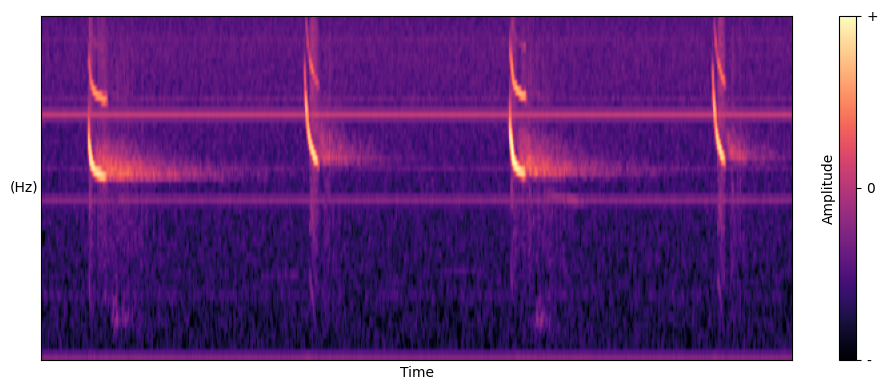

In [26]:
# Some fun spectrogram visuals
extractor = SpectrogramExtractor()
file_name = r"C:\Users\conno\Desktop\UoB_Project\bat.wav"
extractor = SpectrogramExtractor()
log_mel_spec = extractor(file_name)

plt.figure(figsize=(10, 4))
im = plt.imshow(log_mel_spec.squeeze().numpy(), aspect='auto', origin='lower', cmap='magma')
plt.xlabel("Time")
plt.ylabel("(Hz)", rotation=0, labelpad=12, va="center")

# Properly remove ticks
plt.xticks([])
plt.yticks([])

# Colorbar same height as plot
cbar = plt.colorbar(im, location='right')  

# Custom ticks: first, middle, last
cbar_ticks = [im.norm.vmin, (im.norm.vmin + im.norm.vmax) / 2, im.norm.vmax]
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels(['-', '0', '+'])
cbar.set_label("Amplitude", labelpad=-40)

plt.tight_layout()
plt.show()

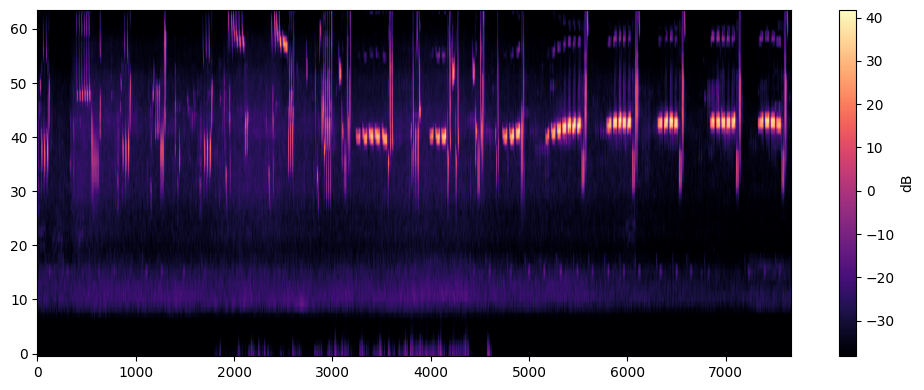

In [7]:
file_name = r"C:\Users\conno\Desktop\UoB_Project\nightingale.mp3"
log_mel_spec = extractor(file_name)

# Plotting
plt.figure(figsize=(10, 4))
plt.imshow(log_mel_spec.squeeze().numpy(), aspect='auto', origin='lower', cmap='magma')
# plt.title("Log-Mel Spectrogram of Bat Echolocation")
# plt.xlabel("Time Frames")
# plt.ylabel("Mel Frequency Bins")
plt.colorbar(label="dB")
plt.tight_layout()
plt.show()

In [26]:
# Load model
model = ConvCount(**config)
model.eval()

# Load spectrogram
spec_path = r"data\specs_libricss\OV40_session9_clip150.pt"
spec = torch.load(spec_path)  # [1, 64, 101]
spec = spec.unsqueeze(0).unsqueeze(0)      # [1, 1, H, W]

# Feature hooks
feature_maps = {}

def get_features(name):
    def hook(module, input, output):
        feature_maps[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_features("conv1"))
model.conv2.register_forward_hook(get_features("conv2"))
model.conv3.register_forward_hook(get_features("conv3"))
model.conv4.register_forward_hook(get_features("conv4"))

# Forward pass
with torch.no_grad():
    out = model(spec)

Conv 1:


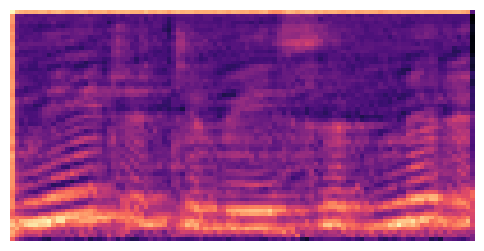

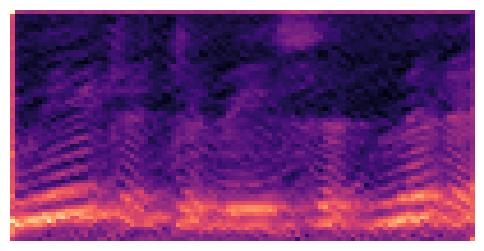

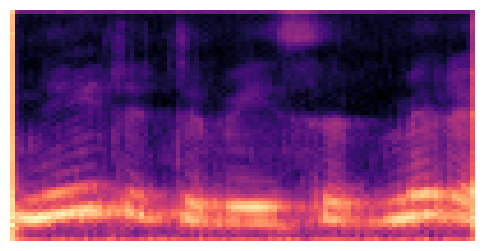

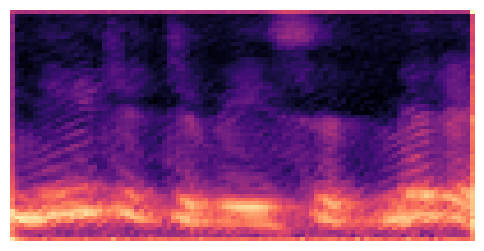

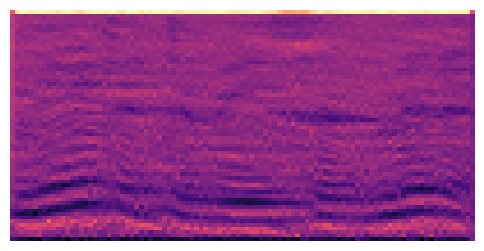

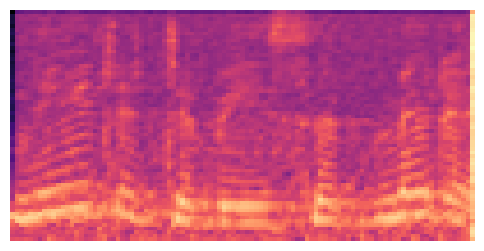

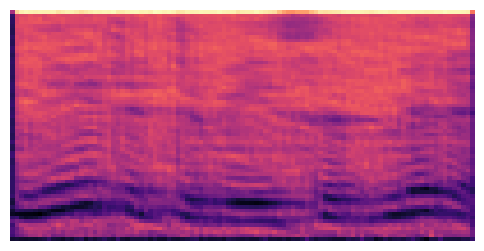

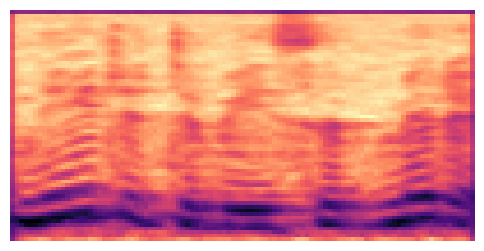

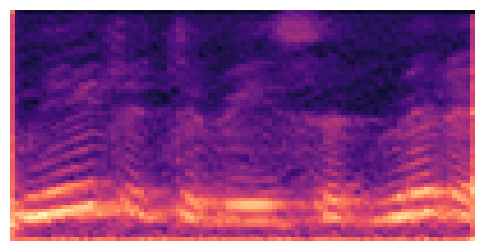

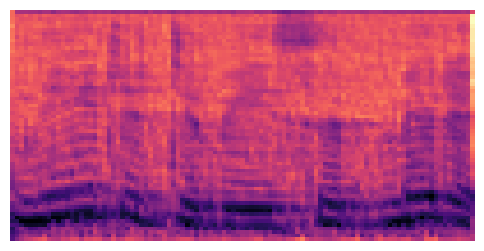

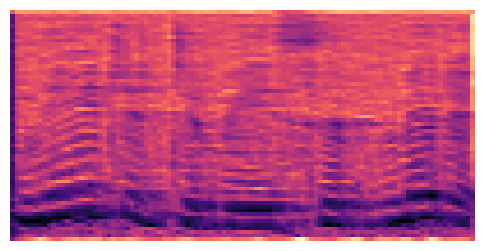

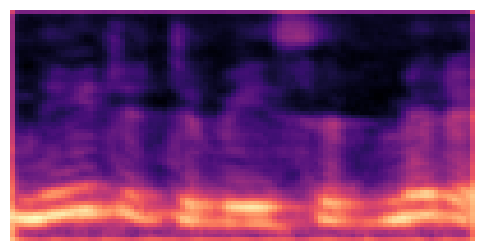

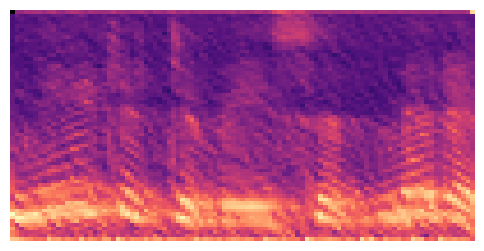

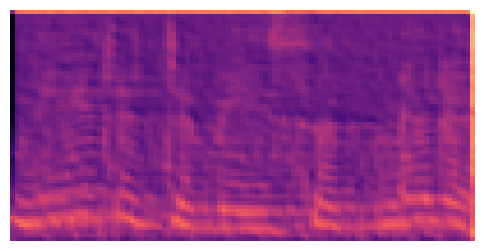

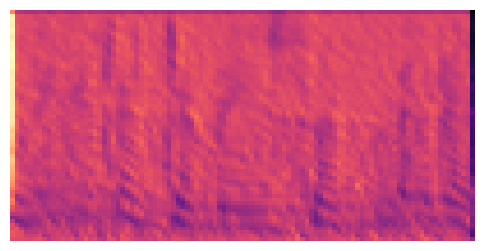

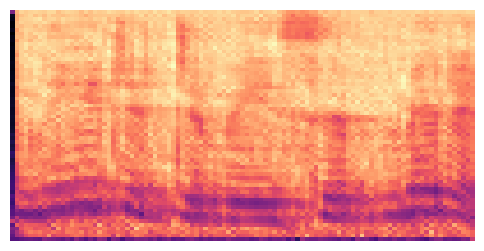

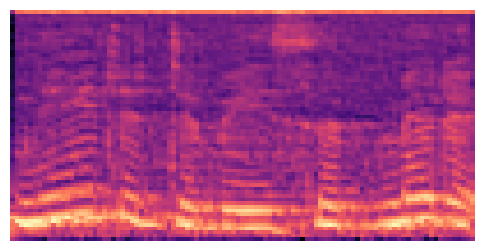

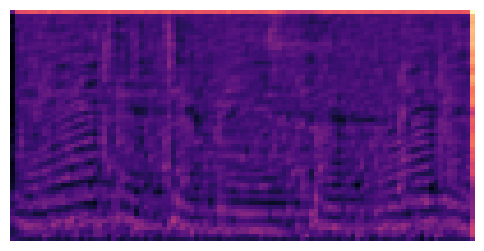

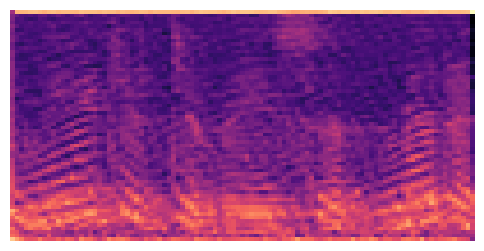

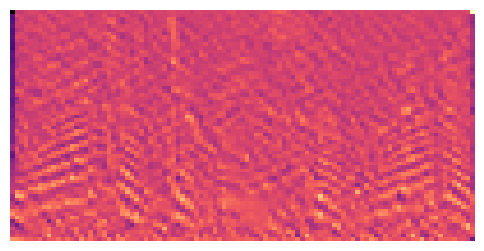

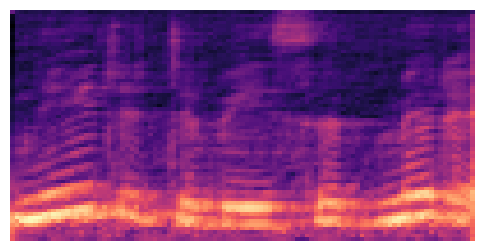

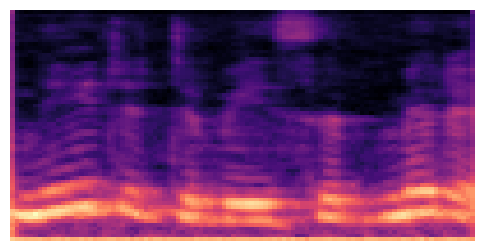

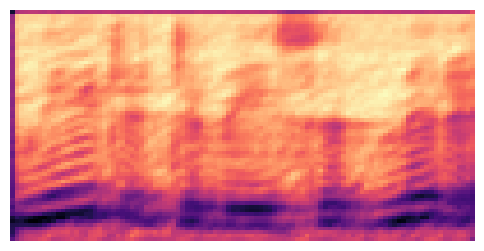

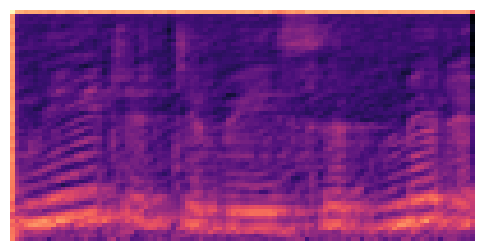

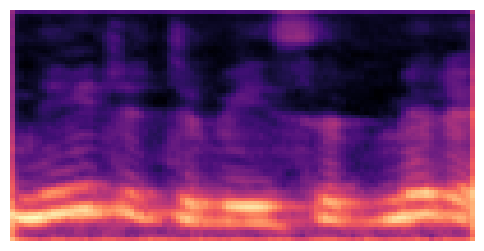

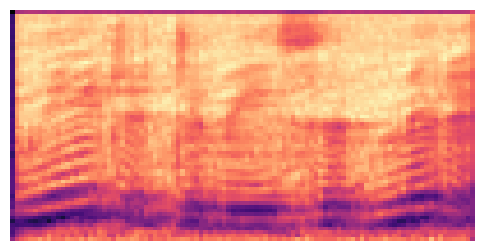

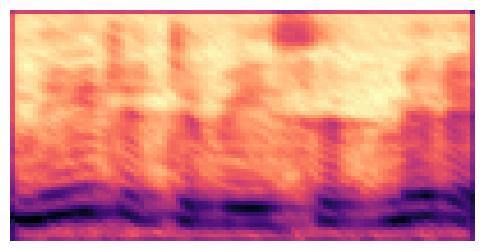

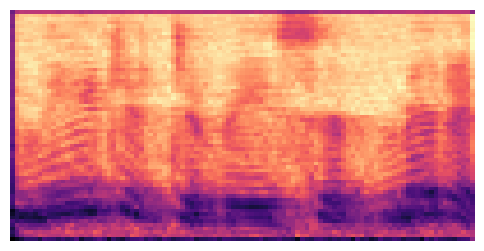

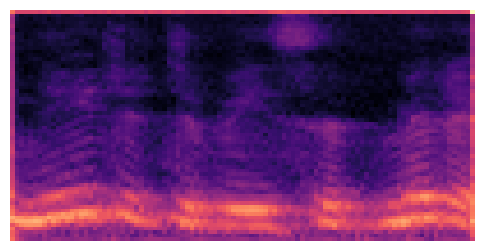

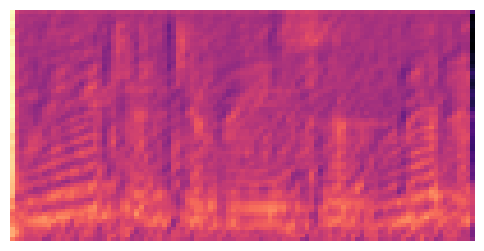

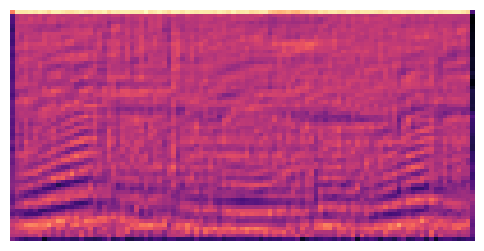

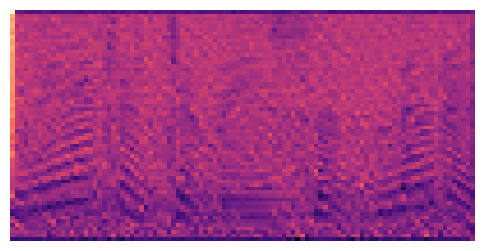

In [27]:
# Display conv1 feature maps
conv1_out = feature_maps["conv1"].squeeze(0)  # [C, H, W]
print("Conv 1:")
for i in range(conv1_out.shape[0]):
    plt.figure(figsize=(6, 3))
    plt.imshow(conv1_out[i].cpu(), aspect='auto', origin='lower', cmap='magma')
    plt.axis('off')
    plt.show()

Conv 2:


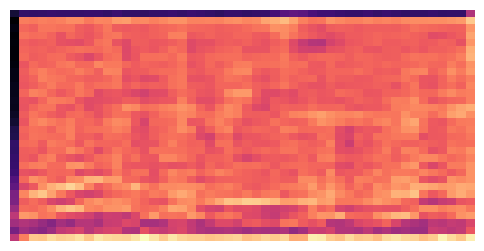

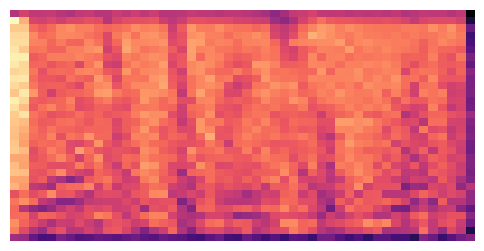

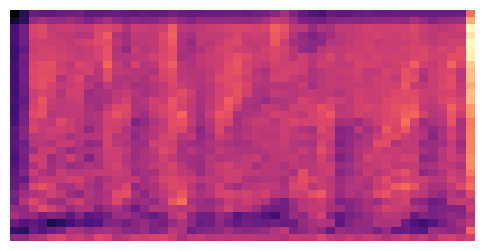

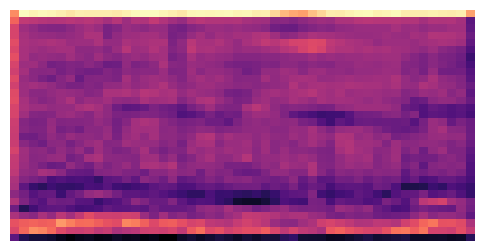

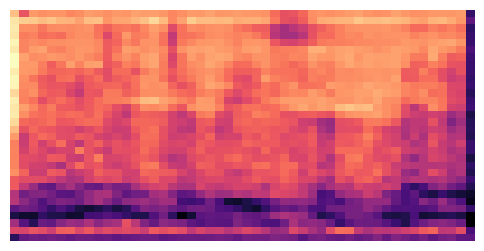

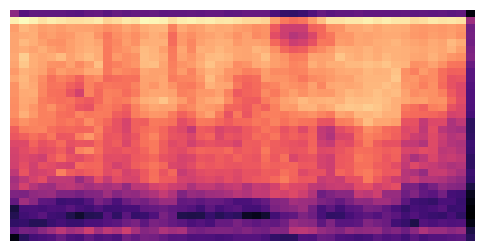

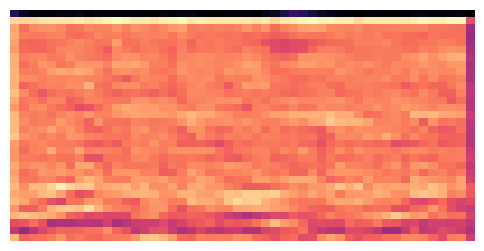

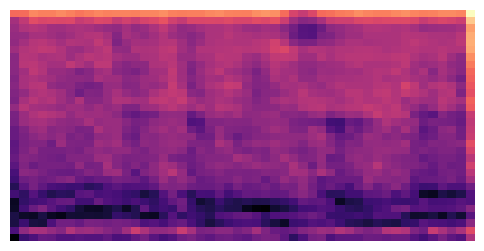

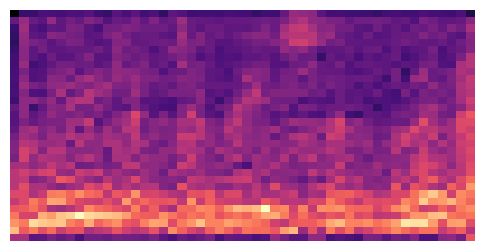

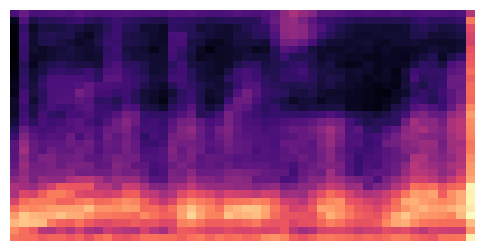

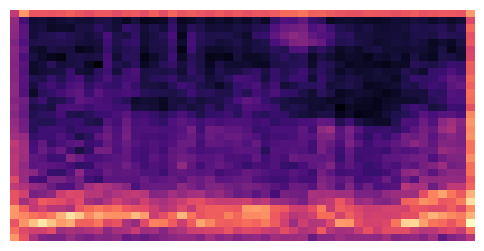

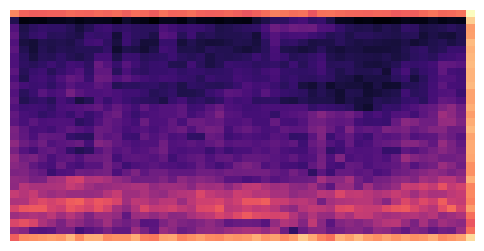

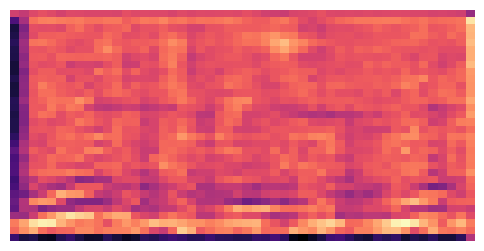

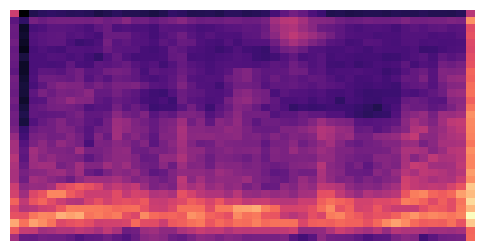

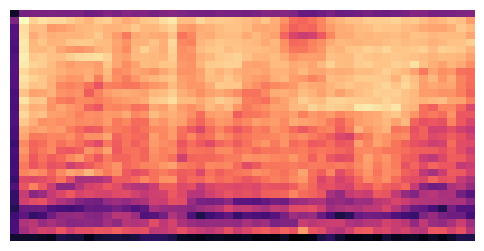

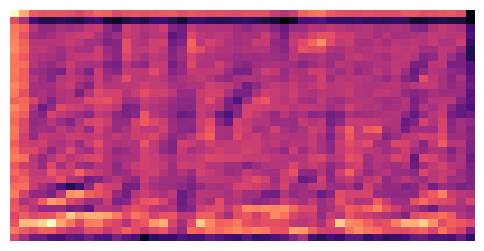

In [28]:
# Display conv2 feature maps
conv2_out = feature_maps["conv2"].squeeze(0)  # [C, H, W]
print("Conv 2:")
for i in range(conv2_out.shape[0]):
    plt.figure(figsize=(6, 3))
    plt.imshow(conv2_out[i].cpu(), aspect='auto', origin='lower', cmap='magma')
    plt.axis('off')
    plt.show()

Conv 3:


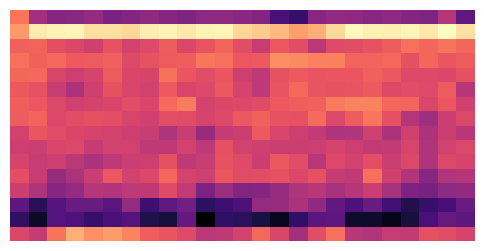

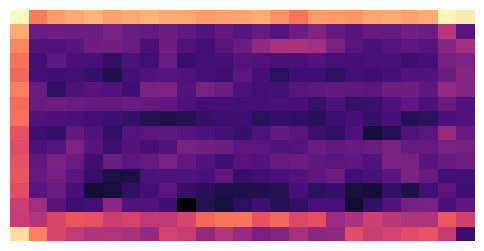

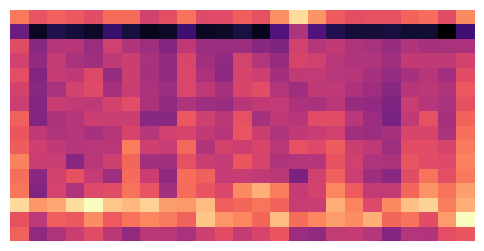

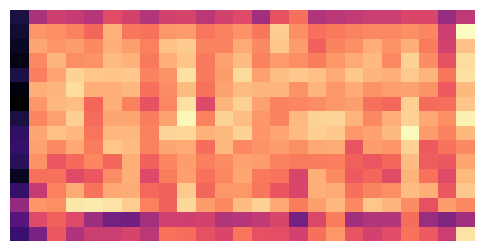

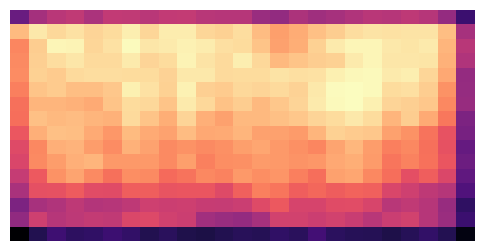

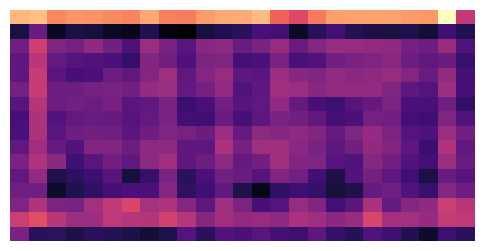

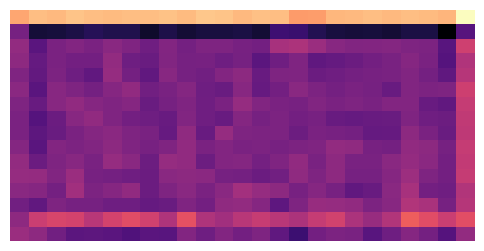

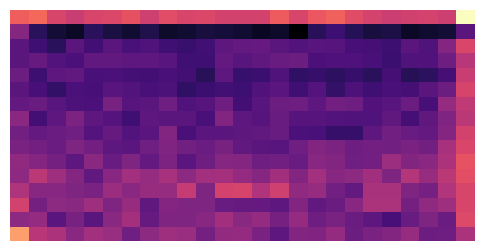

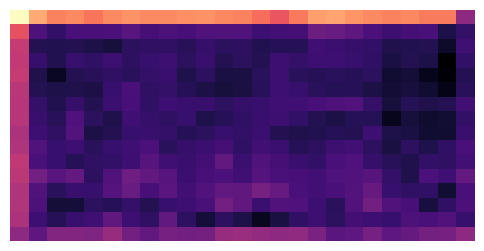

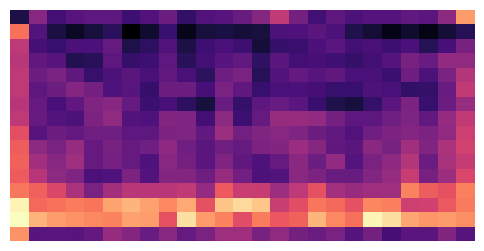

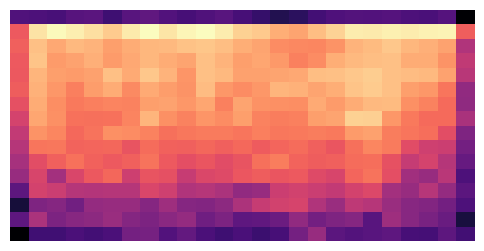

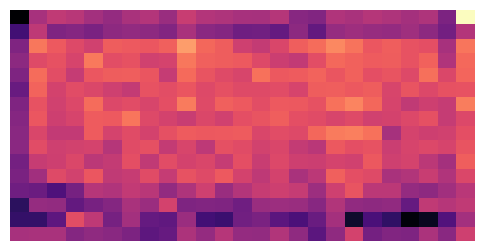

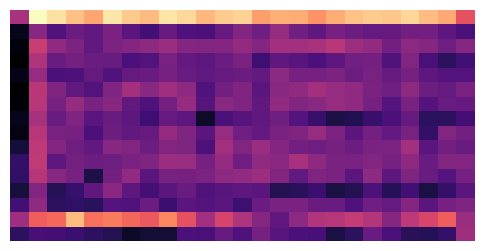

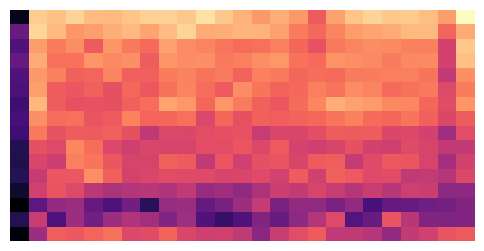

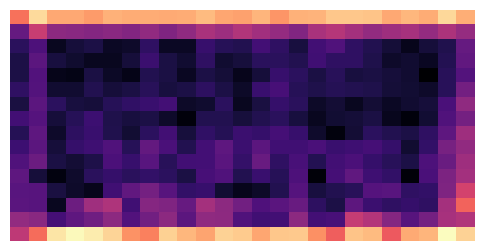

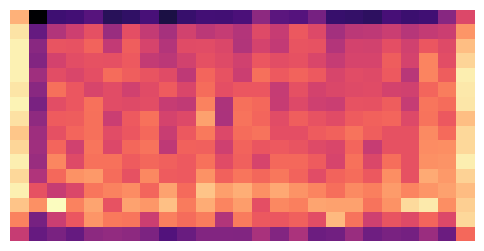

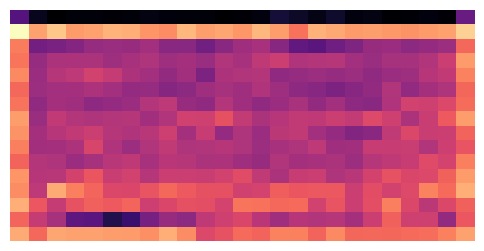

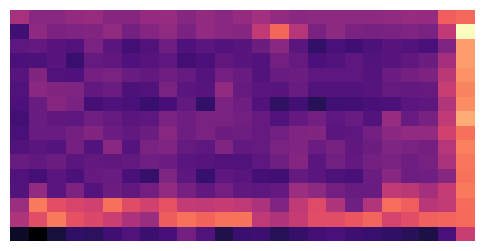

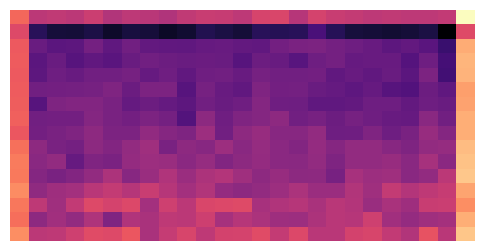

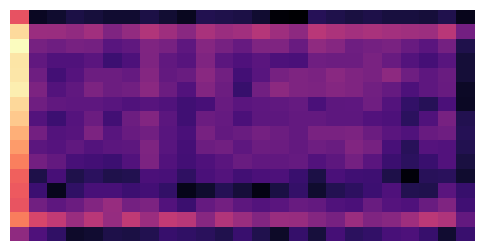

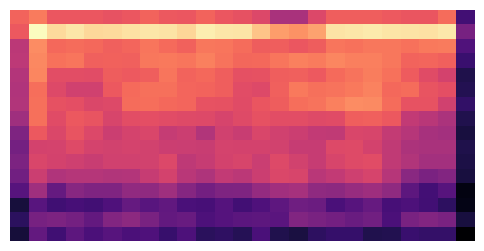

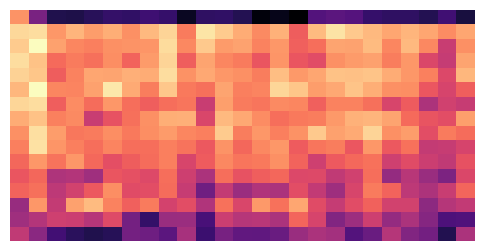

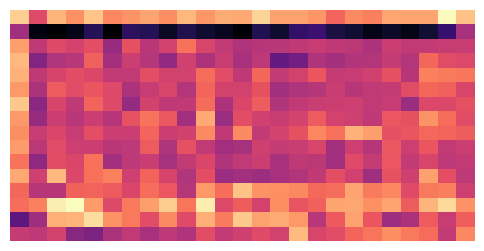

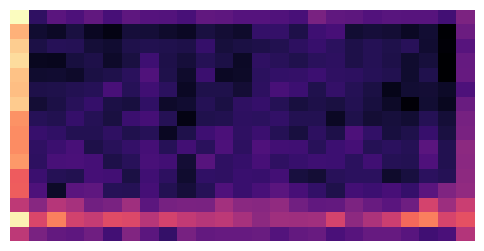

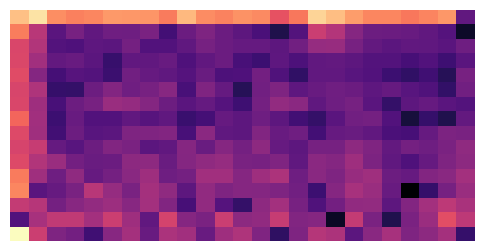

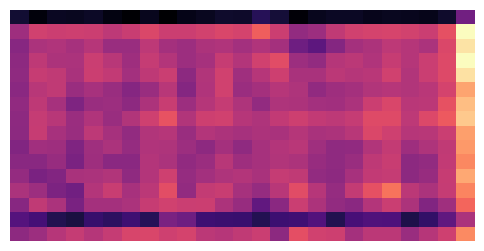

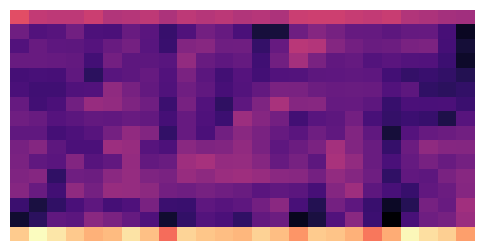

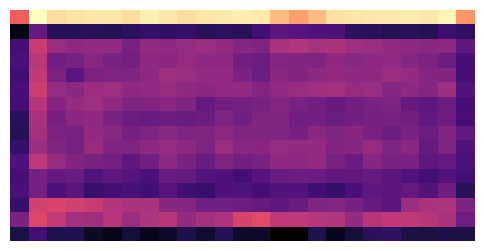

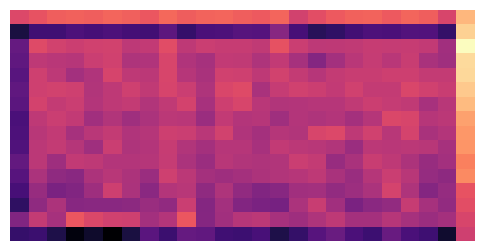

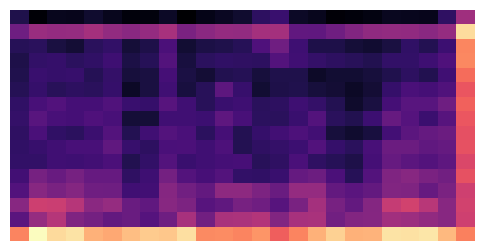

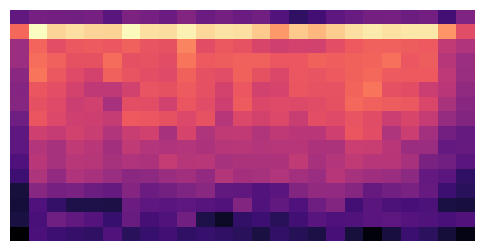

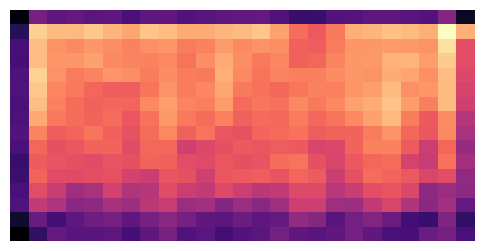

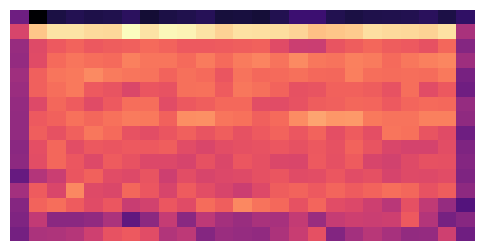

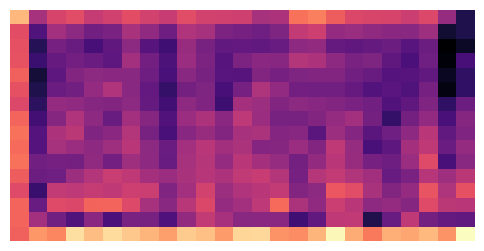

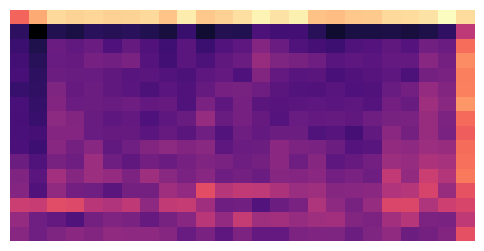

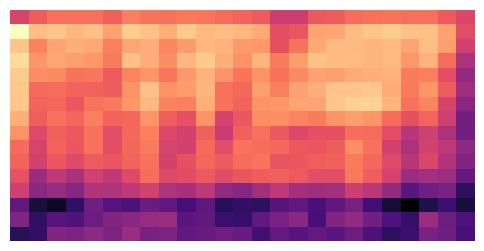

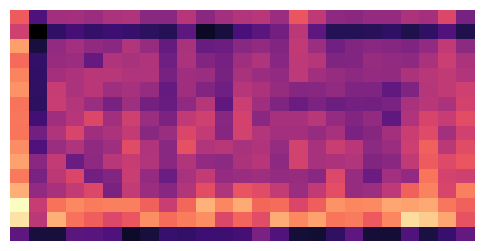

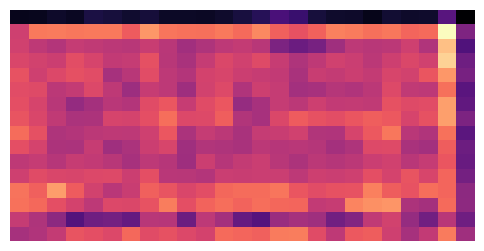

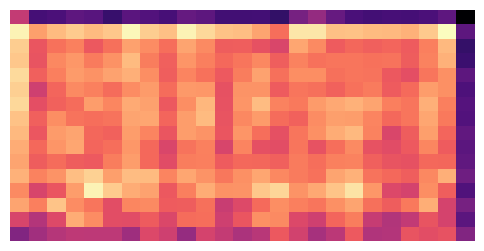

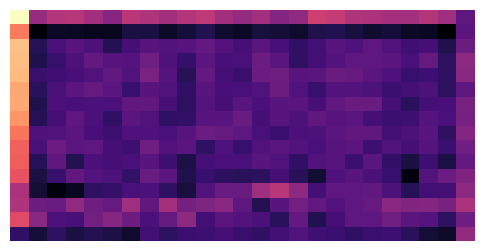

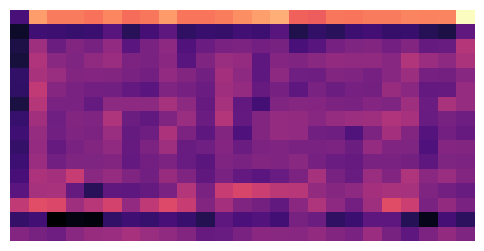

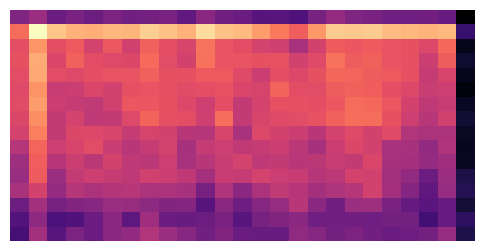

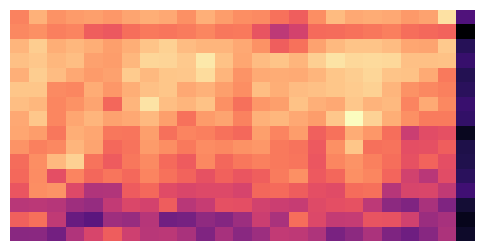

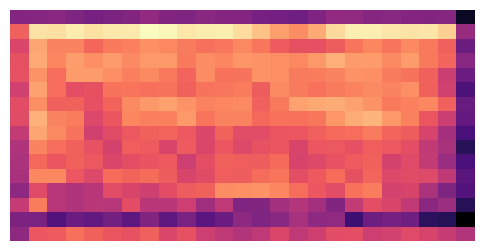

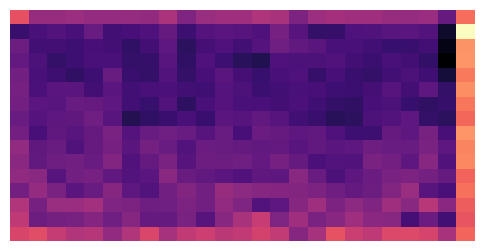

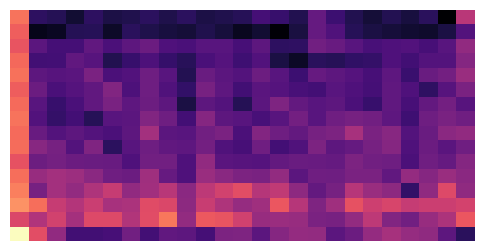

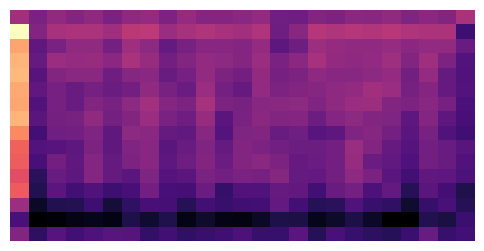

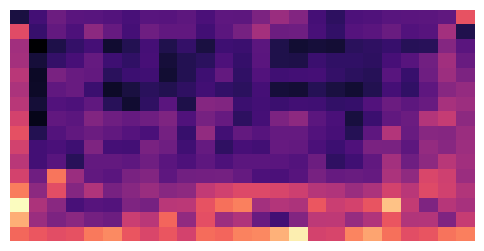

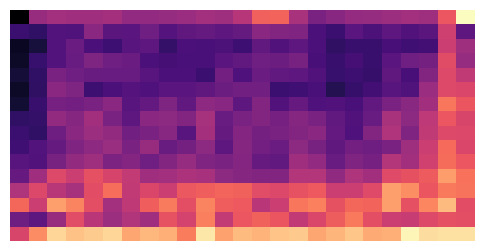

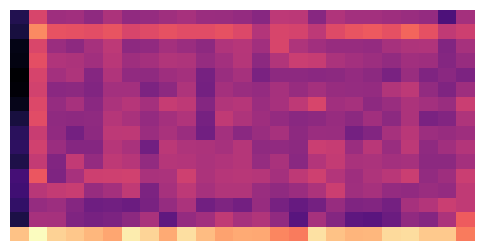

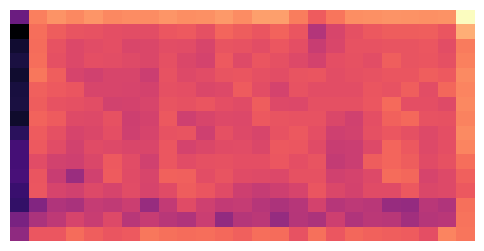

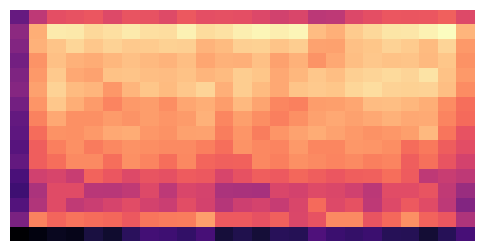

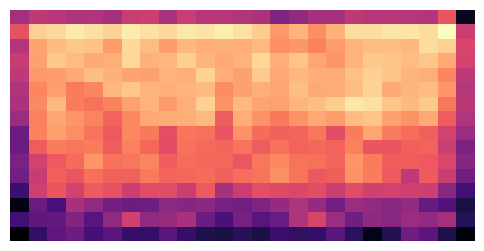

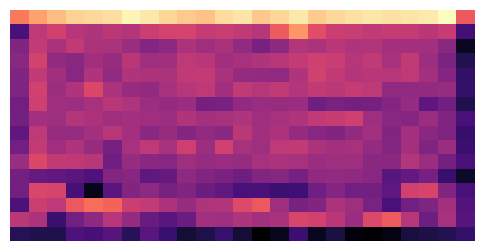

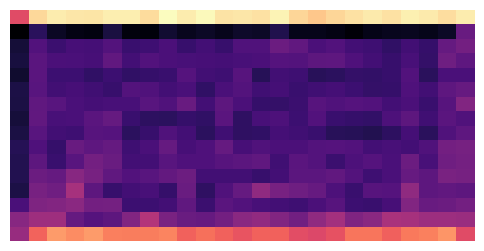

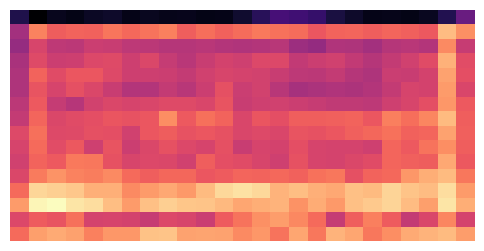

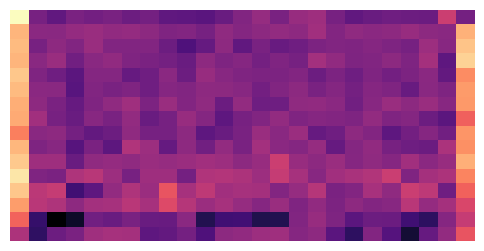

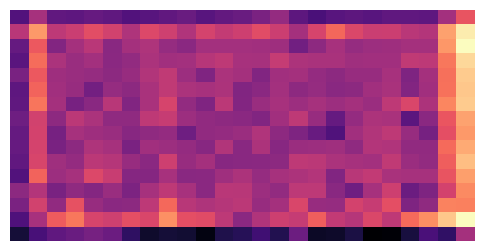

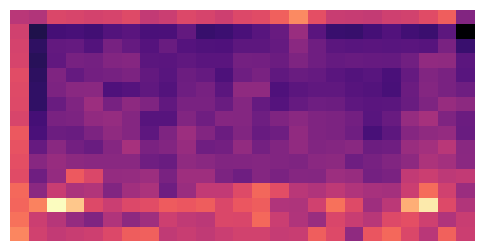

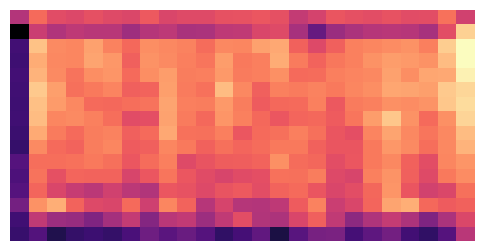

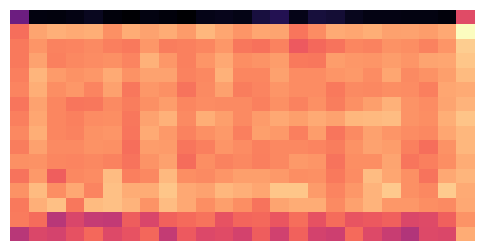

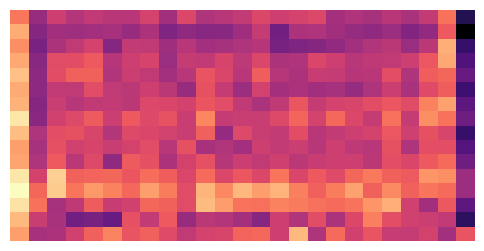

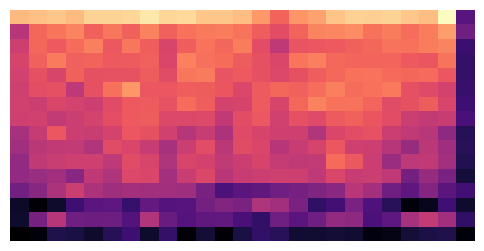

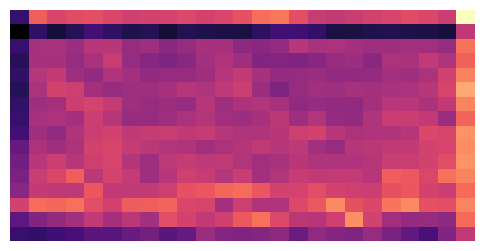

In [31]:
# Display conv3 feature maps
conv3_out = feature_maps["conv3"].squeeze(0)  # [C, H, W]
print("Conv 3:")
for i in range(conv3_out.shape[0]):
    plt.figure(figsize=(6, 3))
    plt.imshow(conv3_out[i].cpu(), aspect='auto', origin='lower', cmap='magma')
    plt.axis('off')
    plt.show()

Conv 4:


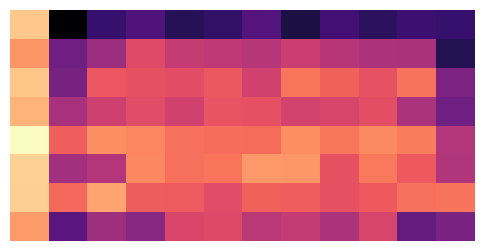

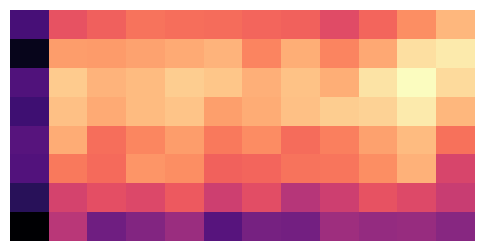

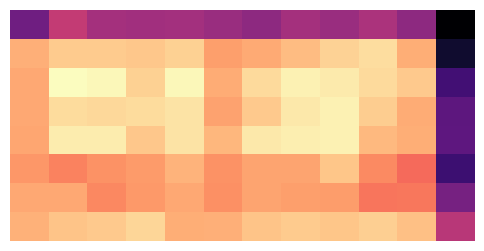

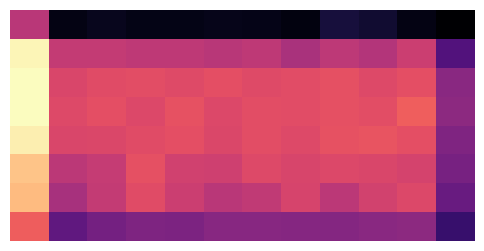

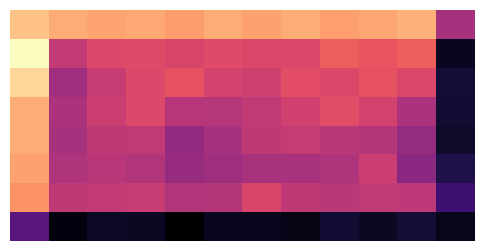

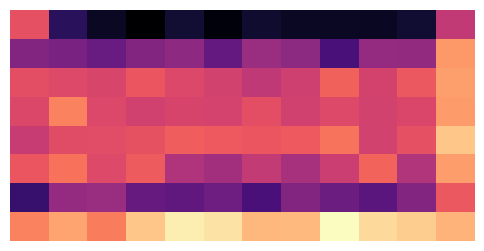

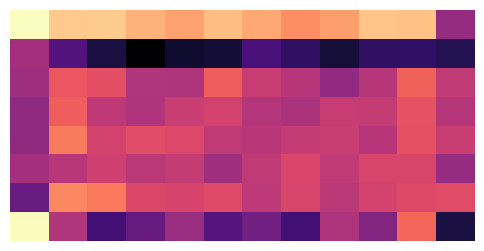

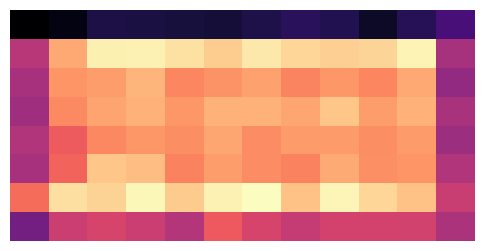

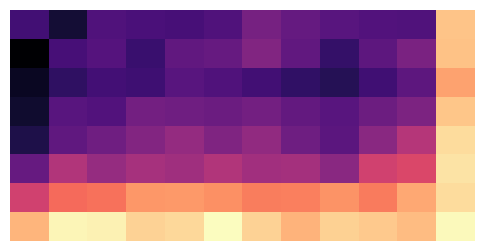

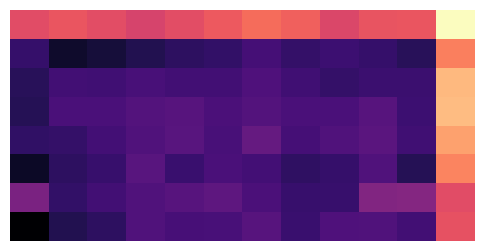

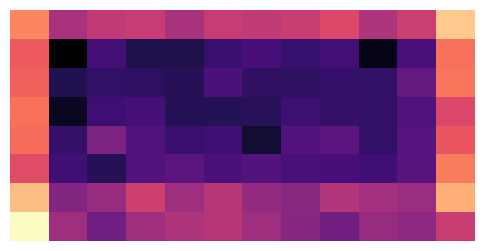

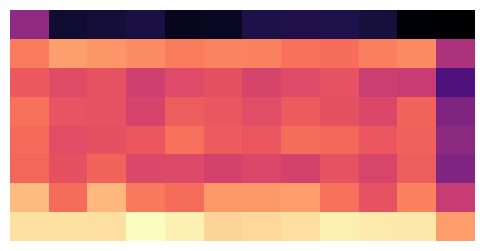

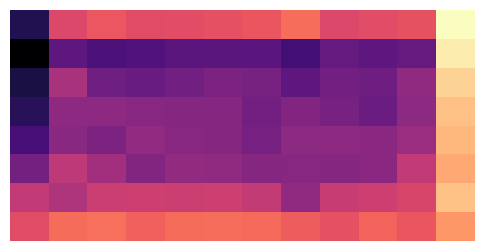

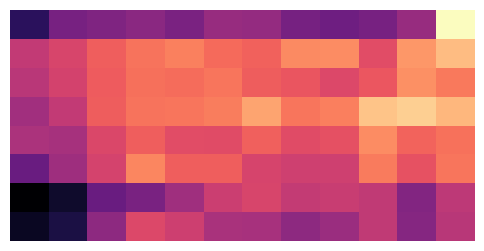

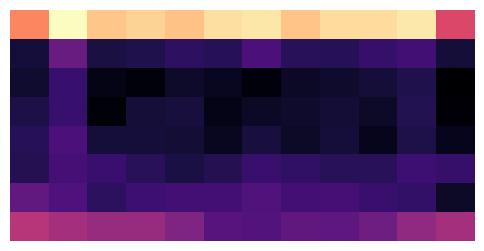

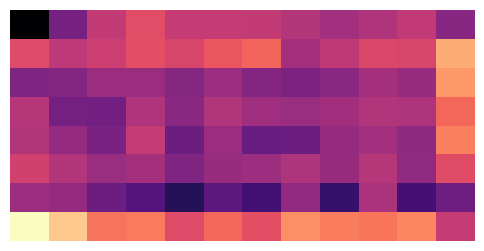

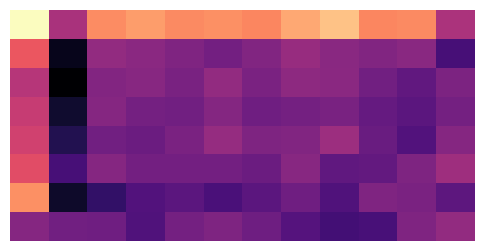

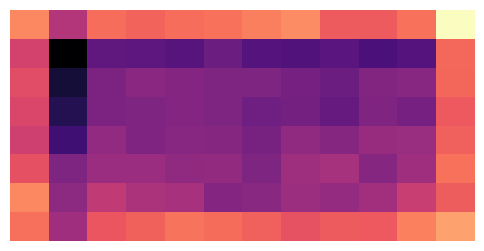

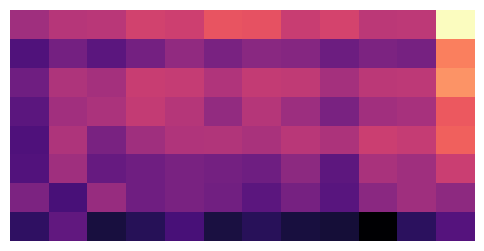

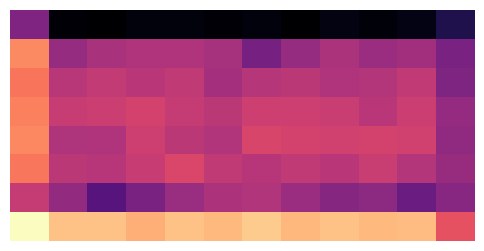

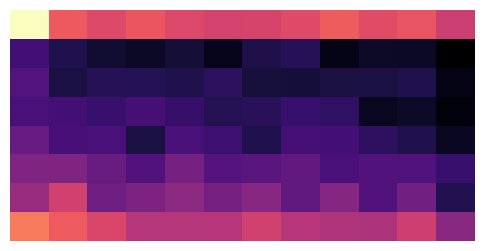

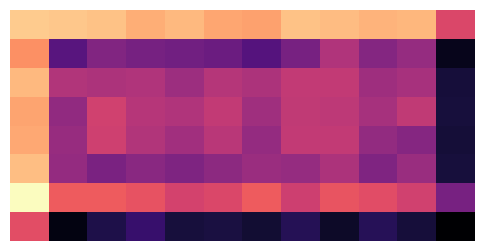

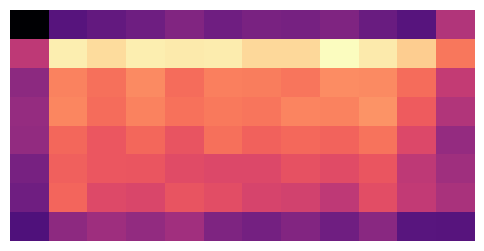

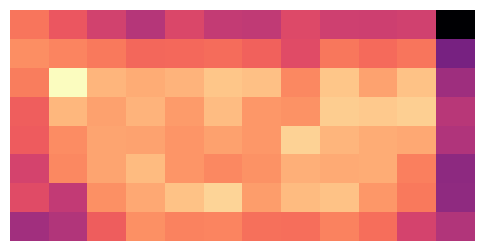

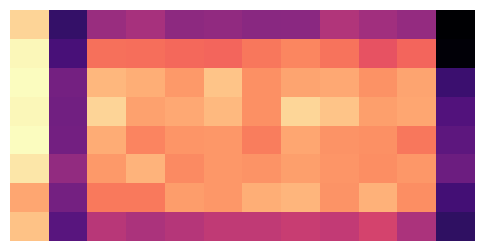

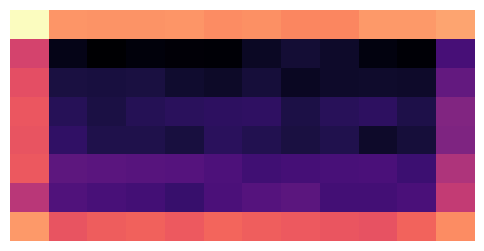

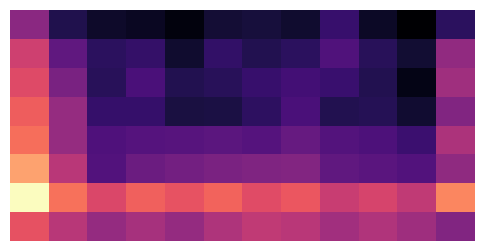

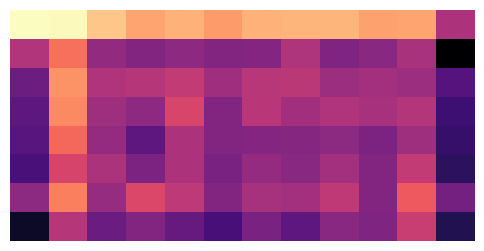

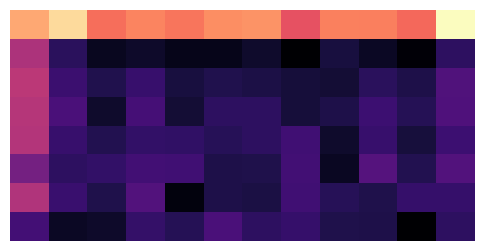

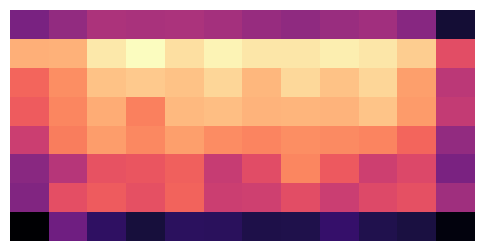

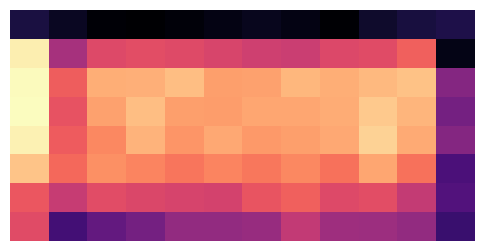

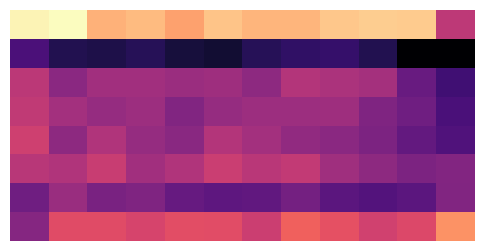

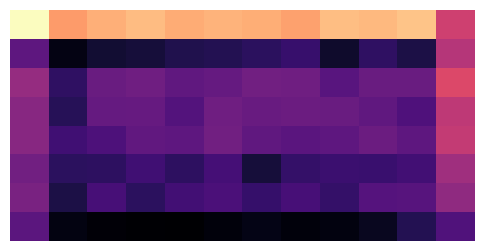

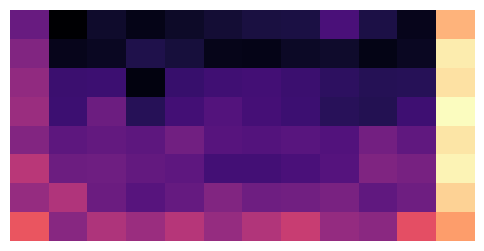

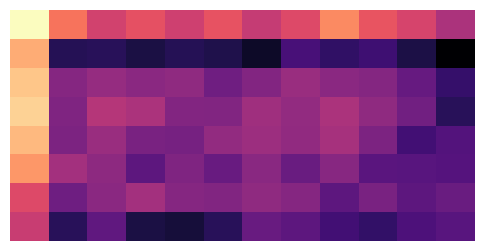

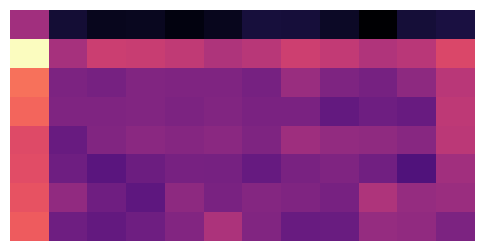

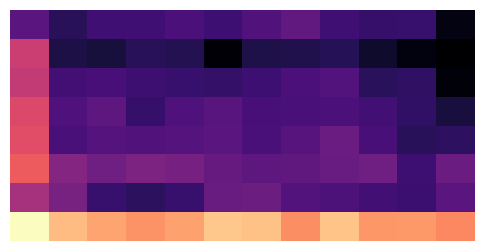

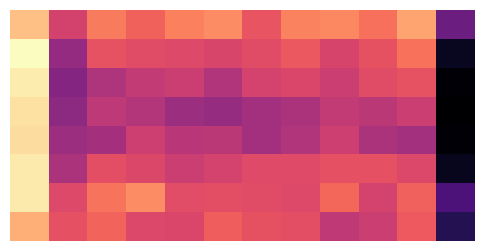

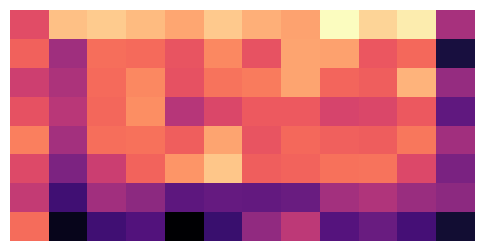

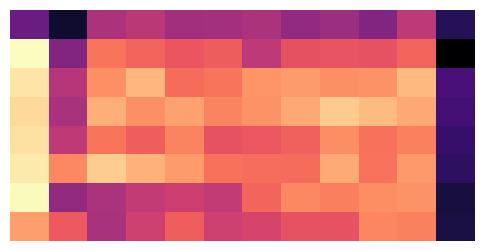

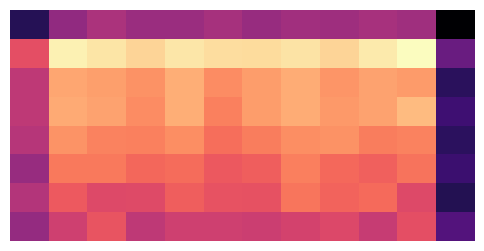

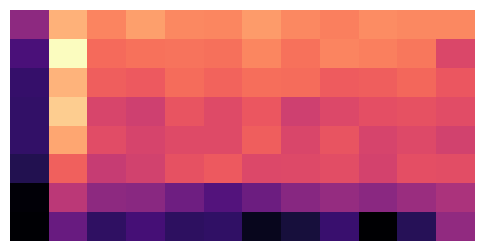

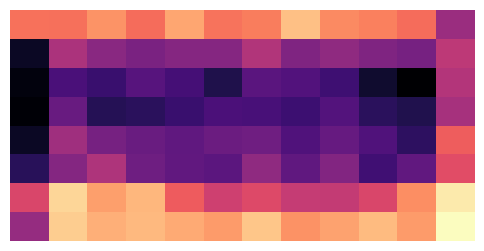

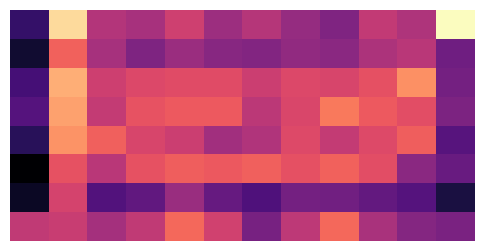

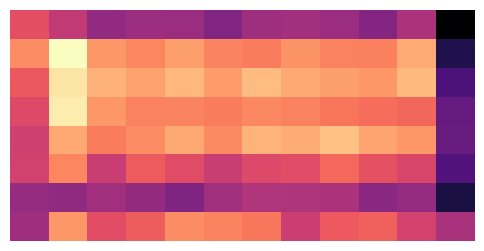

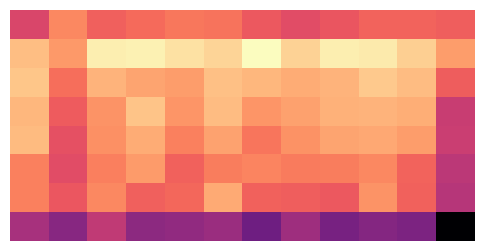

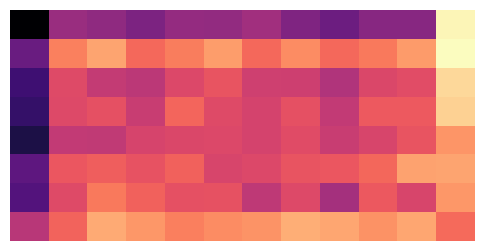

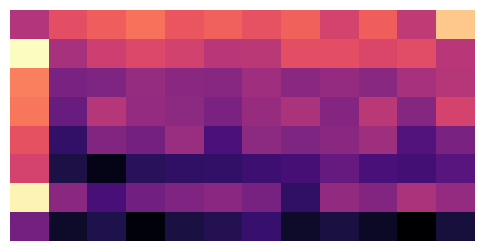

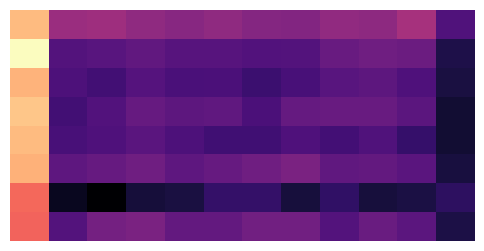

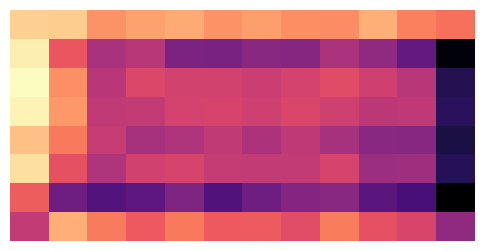

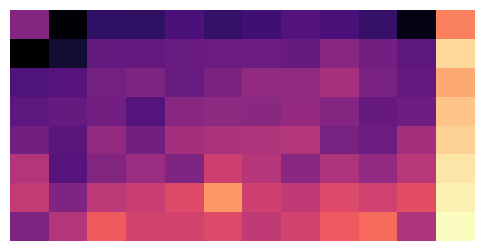

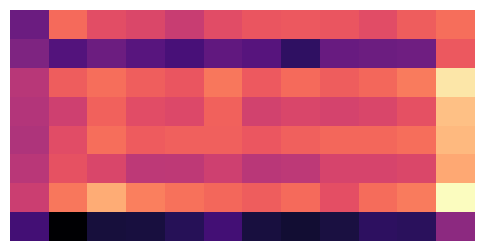

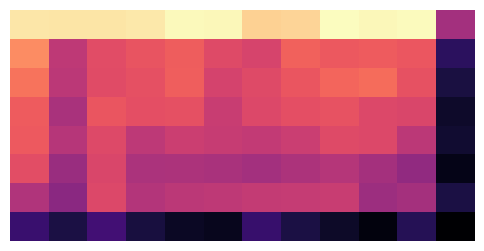

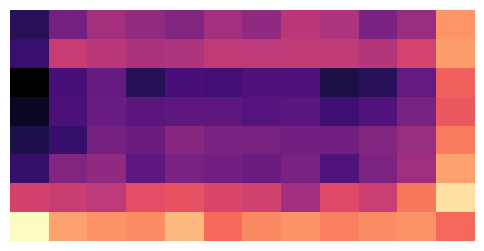

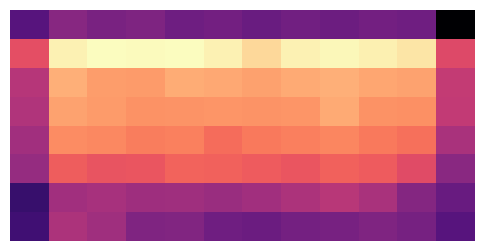

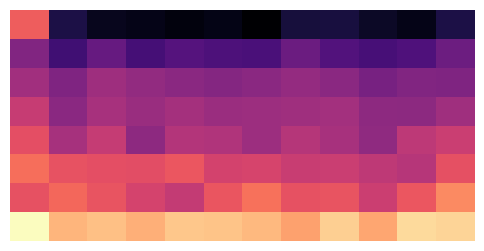

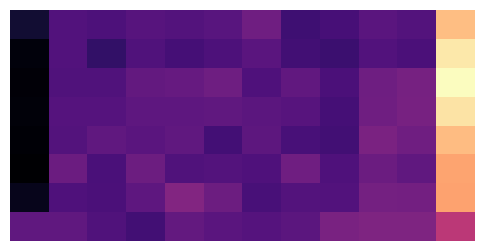

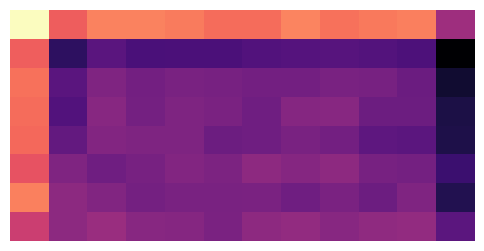

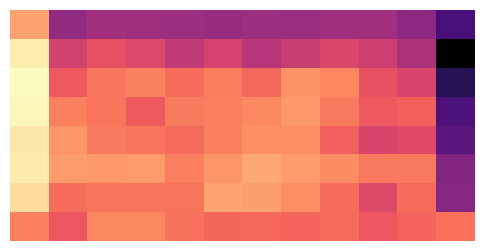

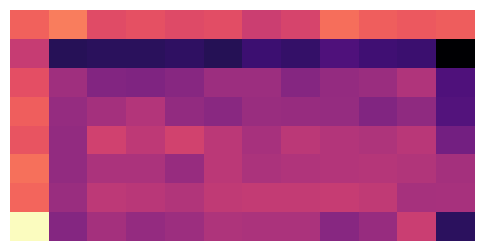

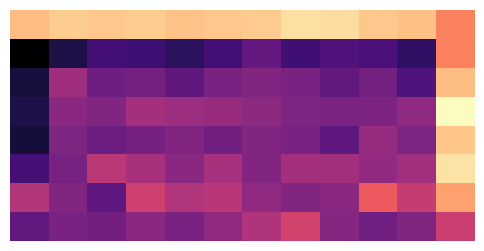

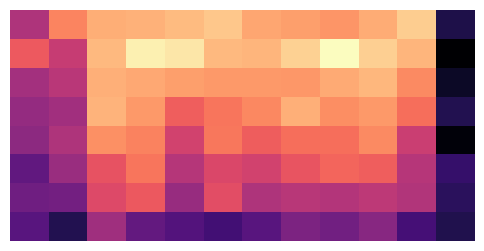

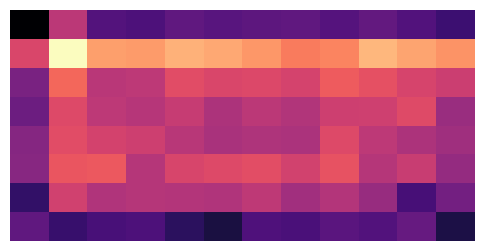

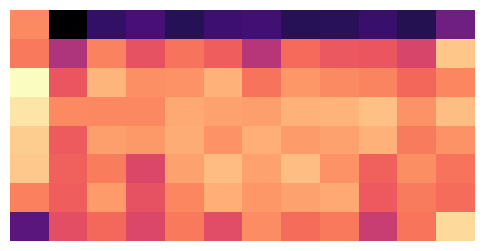

In [32]:
# Display conv4 feature maps
conv4_out = feature_maps["conv4"].squeeze(0)  # [C, H, W]
print("Conv 4:")
for i in range(conv4_out.shape[0]):
    plt.figure(figsize=(6, 3))
    plt.imshow(conv4_out[i].cpu(), aspect='auto', origin='lower', cmap='magma')
    plt.axis('off')
    plt.show()